# Kriging Example 3¶

Author: Mohit S. Chauhan Date: Mar 03, 2019

In this example, Kriging is used to generate a surrogate model for a given data. In this data, sample points are generated using STS class and functional value at sample points are estimated using a model defined in python script ('python_model_function.py).

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS, RunModel and Krig class from UQpy.

In [1]:
from UQpy.Surrogates import Krig
from UQpy.SampleMethods import STS
from UQpy.RunModel import RunModel
import numpy as np
import matplotlib.pyplot as plt

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [2]:
nsamples = 20
x = STS(dimension=1, dist_name=['gamma'], dist_params=[[2, 1, 3]], sts_design=[nsamples])

UQpy: Successful execution of STS design..


RunModel is used to evaluate function values at sample points. Model is defined as a function in python file 'python_model_function.py'. 

In [3]:
rmodel = RunModel(model_script='python_model_1Dfunction.py', verbose=True)
rmodel.run(samples=x.samples)

No samples. Creating the object alone.
The model function that will be run: y_func

Performing serial execution of the model without template input.



A regression model is defined, this function return the basis function and its jacobian. 

In [4]:
def Linear(s):
    s = np.atleast_2d(s)
    fx = np.concatenate((np.ones([np.size(s, 0), 1]), s), 1)
    jf_b = np.zeros([np.size(s, 0), np.size(s, 1), np.size(s, 1)])
    np.einsum('jii->ji', jf_b)[:] = 1
    jf = np.concatenate((np.zeros([np.size(s, 0), np.size(s, 1), 1]), jf_b), 2)
    return fx, jf

Gaussian correlation model is defined, which retur covariance matrix and its derivatives. 

In [5]:
def Gaussian(x, s, params, dt=False, dx=False):
    x = np.atleast_2d(x)
    # Create stack matrix, where each block is x_i with all s
    stack = - np.tile(np.swapaxes(np.atleast_3d(x), 1, 2), (1, np.size(s, 0), 1)) + np.tile(s, (np.size(x, 0), 1, 1))
    rx = np.exp(np.sum(-params * (stack ** 2), axis=2))
    drdt = -(stack ** 2) * np.transpose(np.tile(rx, (np.size(x, 1), 1, 1)), (1, 2, 0))
    drdx = 2 * params * stack * np.transpose(np.tile(rx, (np.size(x, 1), 1, 1)), (1, 2, 0))
    if dt:
        return rx, drdt
    if dx:
        return rx, drdx
    return rx

Using UQpy Krig class to generate a surrogate for generated data. In this illustration, user defined regression model and correlation model are used.

In [6]:
K = Krig(reg_model='Quadratic', corr_model='Gaussian', n_opt=10, dimension=1)
K.fit(samples=x.samples, values=np.array(rmodel.qoi_list))

UQpy: Performing Krig...
Done!


Kriging surrogate is used to compute the response surface and its gradient.

In [7]:
num = 1000
x1 = np.linspace(min(x.samples), max(x.samples), num)
y, mse = K.interpolate(x1.reshape([num, 1]), dy=True)
y_grad = K.jacobian(x1.reshape([num, 1]))

Actual model is evaluated at all points to compare it with kriging surrogate.

In [8]:
rmodel.run(samples=x1)
print(np.array(rmodel.qoi_list).shape)

The model function that will be run: y_func

Performing serial execution of the model without template input.

(1020, 1)


This plot shows the input data as blue dot, blue curve is actual function and orange curve represents response curve. This plot also shows the gradient and 95% confidence interval of the kriging surrogate.

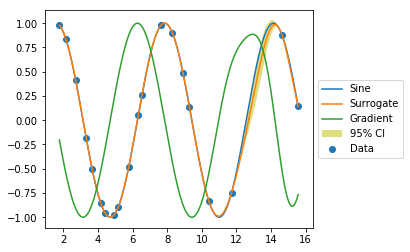

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(x1, np.array(rmodel.qoi_list)[20:1020, :], label='Sine')
plt.plot(x1, y, label='Surrogate')
plt.plot(x1, y_grad, label='Gradient')
plt.scatter(K.samples, K.values, label='Data')
plt.fill(np.concatenate([x1, x1[::-1]]),
         np.concatenate([y - 1.9600 * mse,
                        (y + 1.9600 * mse)[::-1]]),
         alpha=.5, fc='y', ec='None', label='95% CI')
# plt.legend(loc='lower right')
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()